<a href="https://www.kaggle.com/code/alyeko/1-potato-and-tomato-blight-disease-classification?scriptVersionId=105247275" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

The notebook contains the implementation, training and evaluation code for the ResNet-9 model in my thesis: Automatic Blight Disease Detection in Potato and Tomato Plants using Deep Learning'. This notebook also contains the code used to create saliency maps presented in the thesis. 

ResNet-9 model training code in this notebook was adapted from https://www.kaggle.com/code/atharvaingle/plant-disease-classification-resnet-99-2/notebook

### Importing packages used

In [1]:
!pip install torchsummary

In [2]:
import os                                      
import sys
import shap                                    
import torch                                   
import shutil
import optuna
import warnings
import numpy as np                             
import pandas as pd                            
import torch.nn as nn                          
from PIL import Image                          
import seaborn as sns
import matplotlib.pyplot as plt                
import torch.nn.functional as F                
from torchsummary import summary               
from torchvision.utils import make_grid        
from torch.utils.data import DataLoader        
import torchvision.transforms as transforms   
from torchvision.datasets import ImageFolder  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline

### Data exploration!

In [3]:
os.listdir('/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/')

['valid', 'train']

In [4]:
# data_dir = '/kaggle/input/dataset/idata/Image Dataset/ImageDataset/'

data_dir = '/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/'

In [5]:
# print(f"Number of image directories are {len(os.listdir(data_fpath))+len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/'))}\n")
print('Number of unique plants are 2, potato and tomato\n')
print('Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato\n')

Number of unique plants are 2, potato and tomato

Number of diseases are 4, early and late blight disease for tomato, early and late blight for potato



In [6]:
data_dir

'/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/'

In [7]:
# train and validation directories
train_dir = data_dir + "train/"
valid_dir = data_dir + "valid/"
diseases_tr = os.listdir(train_dir)
diseases_va = os.listdir(valid_dir)


In [8]:
valid_dir

'/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/valid/'

In [9]:
diseases_tr

['potato_healthy',
 'potato_early',
 'tomato_healthy',
 'potato_late',
 'tomato_late',
 'tomato_early']

In [10]:
plants = []
NumberOfDiseases = 0
for plant in diseases_tr:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('_')[1] != 'healthy':
        NumberOfDiseases += 1

In [11]:
# Number of images for each clas in the training data
nums_train = {}
for folder in sorted(os.listdir(f"{data_dir}/train")):
    nums_train[folder] = len(os.listdir(f"/{data_dir}/train/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_training_class = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
img_per_training_class

no. of images
potato_early             1998
potato_healthy           2008
potato_late              1998
tomato_early             1998
tomato_healthy           2003
tomato_late              2004

In [12]:
# Number of images for each clas in the training data
nums_valid = {}
for folder in sorted(os.listdir(f"{data_dir}/valid")):
    nums_valid[folder] = len(os.listdir(f"{data_dir}/valid/{folder}"))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_valid_class = pd.DataFrame(nums_valid.values(), index=nums_valid.keys(), columns=["no. of images"])
img_per_valid_class

no. of images
potato_early              221
potato_healthy            221
potato_late               221
tomato_early              221
tomato_healthy            222
tomato_late               225

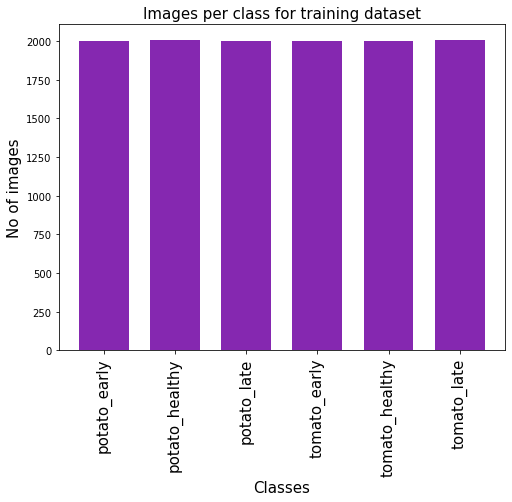

In [13]:
# plotting number of images available for each class
index = [n for n in range(6)]
plt.figure(figsize=(8, 6))
plt.bar(index, [n for n in nums_train.values()], color='#8528B0', width=0.7, align='center')
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_train.keys()], fontsize=15, rotation=90)
plt.title('Images per class for training dataset', fontsize=15)

plt.savefig('/kaggle/working/number_imgs_training.png', dpi=600, bbox_inches="tight")  
plt.show()

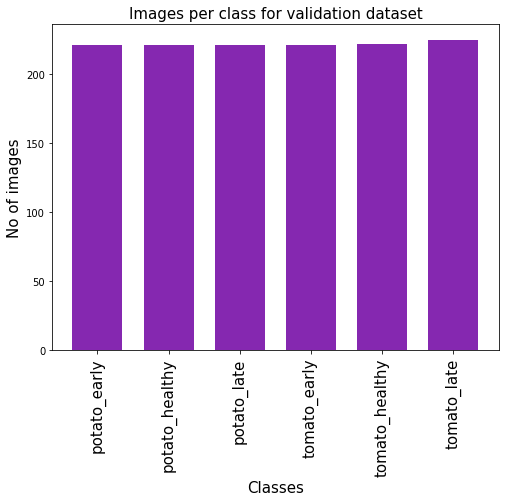

In [14]:
# plotting number of images available for each class
index = [n for n in range(6)]
plt.figure(figsize=(8, 6))
plt.bar(index, [n for n in nums_valid.values()], color='#8528B0', width=0.7) 
plt.xlabel('Classes', fontsize=15)
plt.ylabel('No of images', fontsize=15)
plt.xticks(index, [key for key in nums_valid.keys()], fontsize=15, rotation=90)
plt.title('Images per class for validation dataset', fontsize=15)
# plt.tight_layout()
plt.savefig('/kaggle/working/number_imgs_validation.png', dpi=600, bbox_inches="tight")  
plt.show()

------------------------------------------------

### Data Augmentation

The data has already been augmented. See https://github.com/Alyeko/potato-tomato-blight-disease-detection for the code used to augment the data

Also see description of the dataset used in this notebook -> https://www.kaggle.com/datasets/alyeko/potato-tomato-dataset

------------------------

### Images available for training

In [15]:
n_train = 0
for value in nums_train.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 12009 images for training


In [16]:
n_valid = 0
for value in nums_valid.values():
    n_valid += value
print(f"There are {n_valid} images for validation")

There are 1331 images for validation


In [1]:
#Checking if here are non img files in the training data folder

In [17]:
folds = [folder for folder in os.listdir(train_dir)]
folds

['potato_healthy',
 'potato_early',
 'tomato_healthy',
 'potato_late',
 'tomato_late',
 'tomato_early']

In [18]:
for i in folds:
    for img in os.listdir(train_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [19]:
for i in folds:
    for img in os.listdir(valid_dir+i):
        if not img.endswith('.JPG'):
            print('yes!')

In [20]:
data_dir

'/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/'

In [21]:
print(f"There are {len(os.listdir('/kaggle/input/dataset/idata/Image Dataset/test_data/test'))} images for test")

There are 1332 images for test


In [22]:
print(f"Training dir: {os.listdir('/kaggle/input/dataset/idata/Image Dataset/ImageDataset/')}")
print(f"All: {os.listdir('/kaggle/input/dataset/idata/Image Dataset')}")

Training dir: ['valid', 'train']
All: ['test_data', 'ImageDataset']


In [23]:
test_dir = '/kaggle/input/dataset/idata/Image Dataset/test_data/'
# print(f"There are {len(os.listdir('/kaggle/input/newds/ImageDataset_new/ImageDataset_new/test_data'))} images for training")
os.listdir(test_dir)

['test']

In [24]:
for img in os.listdir(test_dir+'test'):
        if not img.endswith('.JPG'):
            print('Yes! I knew it!')

Yes! I knew it!


------------------------

### Data preparation for training 

In [25]:
print(train_dir)
print(valid_dir)

/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/train/
/kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/valid/


In [26]:
# datasets for validation and training
train = ImageFolder(train_dir, transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

valid = ImageFolder(valid_dir, transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

In [27]:
#Image shape
img, label = train[4590]
print(img.shape, label)

img, label = train[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 2
torch.Size([3, 256, 256]) 0


We can see the shape (3, 256 256) of the image. 3 is the number of channels (RGB) and 256 x 256 is the width and height of the image

In [28]:
len(train.classes) #multiclass classification with 6 classes

6

In [29]:
# for checking some images from training dataset
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    plt.imshow(image.permute(1, 2, 0))
    

In [30]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

Label :tomato_healthy(4)


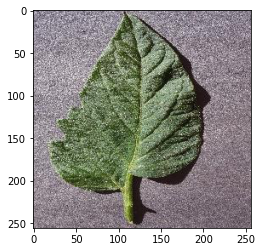

In [31]:
show_image(*train[10000])

Label :tomato_early(3)


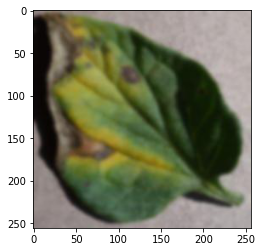

In [32]:
show_image(*train[6580])

Label :potato_early(0)


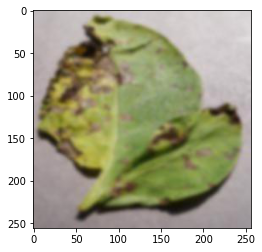

In [33]:
show_image(*train[1000])

Label :potato_late(2)


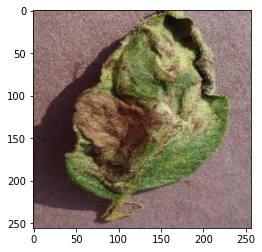

In [34]:
show_image(*train[5000])

In [35]:
print(train, '\n')
print(valid)

Dataset ImageFolder
    Number of datapoints: 12009
    Root location: /kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/train/
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           ) 

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: /kaggle/input/potato-tomato-dataset/idata/Image Dataset/ImageDataset/valid/
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [36]:
# DataLoaders for training and validation
# setting the batch size
batch_size = 32
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

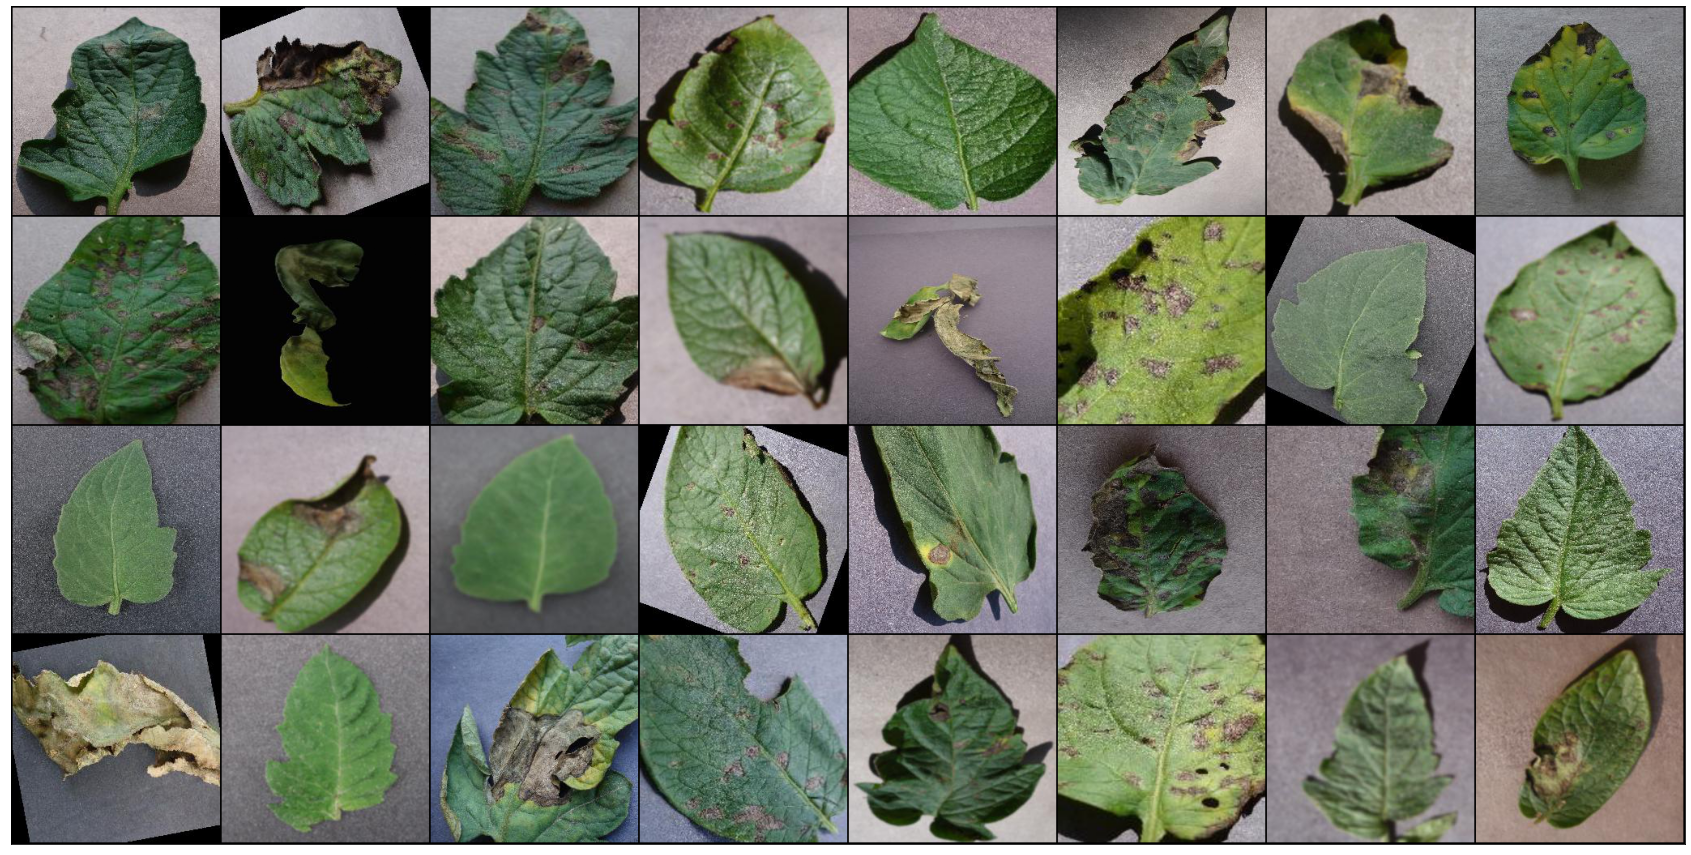

In [37]:
# helper function to show a batch of training instances
def show_batch(data):
    for images, labels in data:
        fig, ax = plt.subplots(figsize=(30, 30))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
        
# Images for first batch of training
show_batch(train_dl) 

------------------------

### Functions used to build the ResNet-9 model 

In [38]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [39]:
device = get_default_device()
device

device(type='cuda')

In [40]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [41]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [42]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


# base class for the model
# base class for the model
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        train_acc = accuracy(out, labels)
        return loss
    
    def training_step_4_acc(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        train_acc = accuracy(out, labels)
        return train_acc
        
        
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}
    
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss  
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_accuracy']))
        

#### ResNet-9 model implementation

In [43]:
# Architecture for training
# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# resnet architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases),
                                       nn.Softmax(dim=1)
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out        

In [44]:
#defining the model 
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [45]:
#getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [46]:
#functions for training the network, added my code
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, momentum=0, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay, momentum)
         
    
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            t_acc = model.training_step_4_acc(batch)
            train_losses.append(loss)
            train_accuracies.append(t_acc)
            loss.backward()
            
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history
    

In [47]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 3.05 s, sys: 423 ms, total: 3.47 s
Wall time: 8.11 s


[{'val_loss': tensor(1.7928, device='cuda:0'), 'val_accuracy': tensor(0.1570)}]

------------------------

### Hyperparamter tuning with Optuna

Code for hyperparameter tuning adapted from https://towardsdatascience.com/hyperparameter-tuning-of-neural-networks-with-optuna-and-pytorch-22e179efc837

In [51]:
def train_and_evaluate(param, model, train_loader, val_loader, trial):
    torch.cuda.empty_cache()
    history = []
    
    #optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    #opt_func = getattr(torch.optim, param['optimizer'])
    optimizer = getattr(torch.optim, param['optimizer'])(model.parameters(), lr=param['initial_lr'], weight_decay=param['weight_decay'], momentum=param['momentum'])

        
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, param['initial_lr'], epochs=param['epochs'], steps_per_epoch=len(train_loader))

    for epoch in range(param['epochs']):
        # Training
        model.train()
        train_losses = []
        train_accuracies = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            t_acc = model.training_step_4_acc(batch)
            train_losses.append(loss)
            train_accuracies.append(t_acc)
            loss.backward()
            
            # gradient clipping
            if param['grad_clip']: 
                nn.utils.clip_grad_value_(model.parameters(), param['grad_clip'])
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracies).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        val_acc_last_epoch = history[-1]['val_accuracy'].item()   
        
        trial.report(val_acc_last_epoch, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        
        return val_acc_last_epoch 

In [52]:
def objective(trial):
    params = {'initial_lr': trial.suggest_loguniform('initial_lr', 0.01, 0.06),
              'optimizer': trial.suggest_categorical("optimizer", ["SGD"]),
              'weight_decay': trial.suggest_loguniform('weight_decay', 1e-4, 1e-1),
              'grad_clip': trial.suggest_float('grad_clip', 0.1, 0.5),
              'epochs' : trial.suggest_int('epochs', 8, 25), 
              'momentum' : trial.suggest_float('momentum', 0, 1),
              }
    
    val_accuracy = train_and_evaluate(params, model, train_dl, valid_dl, trial)
    return val_accuracy #train_and_evaluate(params, model, train_dl, valid_dl)

In [53]:
%%time
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=60)

[I 2022-09-05 21:49:46,299] A new study created in memory with name: no-name-20f931e6-83bb-4b5c-91ca-5606c697f531
[I 2022-09-05 21:51:44,868] Trial 0 finished with value: 0.4490131735801697 and parameters: {'initial_lr': 0.05484328439867692, 'optimizer': 'SGD', 'weight_decay': 0.003289414671415328, 'grad_clip': 0.33025747543259515, 'epochs': 16, 'momentum': 0.21534837845242794}. Best is trial 0 with value: 0.4490131735801697.


Epoch [0], last_lr: 0.00761, train_loss: 1.4467, train_accuracy: 0.5899, val_loss: 1.5952, val_acc: 0.4490


[I 2022-09-05 21:53:43,190] Trial 1 finished with value: 0.6929041743278503 and parameters: {'initial_lr': 0.01968583932486443, 'optimizer': 'SGD', 'weight_decay': 0.0032731068947089714, 'grad_clip': 0.29184242432136276, 'epochs': 15, 'momentum': 0.5823429852695736}. Best is trial 1 with value: 0.6929041743278503.


Epoch [0], last_lr: 0.00299, train_loss: 1.2988, train_accuracy: 0.7413, val_loss: 1.3448, val_acc: 0.6929


[I 2022-09-05 21:55:41,333] Trial 2 finished with value: 0.8732377886772156 and parameters: {'initial_lr': 0.05123741158163603, 'optimizer': 'SGD', 'weight_decay': 0.0001547686768663422, 'grad_clip': 0.29935484753749153, 'epochs': 17, 'momentum': 0.11133689474152542}. Best is trial 2 with value: 0.8732377886772156.


Epoch [0], last_lr: 0.00655, train_loss: 1.2179, train_accuracy: 0.8246, val_loss: 1.1718, val_acc: 0.8732


[I 2022-09-05 21:57:39,290] Trial 3 finished with value: 0.9518718719482422 and parameters: {'initial_lr': 0.012134658576194262, 'optimizer': 'SGD', 'weight_decay': 0.062420089263470396, 'grad_clip': 0.11785076882556189, 'epochs': 12, 'momentum': 0.4898822023635736}. Best is trial 3 with value: 0.9518718719482422.


Epoch [0], last_lr: 0.00256, train_loss: 1.0796, train_accuracy: 0.9694, val_loss: 1.1129, val_acc: 0.9519


[I 2022-09-05 21:59:38,109] Trial 4 finished with value: 0.9672619104385376 and parameters: {'initial_lr': 0.015586060162007042, 'optimizer': 'SGD', 'weight_decay': 0.05000696550756083, 'grad_clip': 0.469036952170945, 'epochs': 25, 'momentum': 0.7958002536892685}. Best is trial 4 with value: 0.9672619104385376.


Epoch [0], last_lr: 0.00127, train_loss: 1.0714, train_accuracy: 0.9887, val_loss: 1.0934, val_acc: 0.9673


[I 2022-09-05 22:01:36,735] Trial 5 finished with value: 0.974193274974823 and parameters: {'initial_lr': 0.013845633718398134, 'optimizer': 'SGD', 'weight_decay': 0.017860336796416545, 'grad_clip': 0.3037472579947019, 'epochs': 21, 'momentum': 0.8118780458541482}. Best is trial 5 with value: 0.974193274974823.


Epoch [0], last_lr: 0.00136, train_loss: 1.0719, train_accuracy: 0.9899, val_loss: 1.0855, val_acc: 0.9742


[I 2022-09-05 22:03:34,702] Trial 6 finished with value: 0.9680059552192688 and parameters: {'initial_lr': 0.01124729147498237, 'optimizer': 'SGD', 'weight_decay': 0.00015941869110816179, 'grad_clip': 0.16688715721080727, 'epochs': 21, 'momentum': 0.8534168353108822}. Best is trial 5 with value: 0.974193274974823.


Epoch [0], last_lr: 0.00110, train_loss: 1.0613, train_accuracy: 0.9930, val_loss: 1.0897, val_acc: 0.9680


[I 2022-09-05 22:05:33,026] Trial 7 finished with value: 0.9642465710639954 and parameters: {'initial_lr': 0.018364689761737524, 'optimizer': 'SGD', 'weight_decay': 0.0011263512240195944, 'grad_clip': 0.16752762756177053, 'epochs': 17, 'momentum': 0.3210979568457072}. Best is trial 5 with value: 0.974193274974823.


Epoch [0], last_lr: 0.00235, train_loss: 1.0603, train_accuracy: 0.9922, val_loss: 1.0885, val_acc: 0.9642


[I 2022-09-05 22:07:31,175] Trial 8 pruned. 


Epoch [0], last_lr: 0.00493, train_loss: 1.0587, train_accuracy: 0.9923, val_loss: 1.1555, val_acc: 0.9040


[I 2022-09-05 22:09:29,435] Trial 9 pruned. 


Epoch [0], last_lr: 0.00548, train_loss: 1.0632, train_accuracy: 0.9876, val_loss: 1.1531, val_acc: 0.8963


[I 2022-09-05 22:11:27,392] Trial 10 finished with value: 0.9776785969734192 and parameters: {'initial_lr': 0.02822508160695285, 'optimizer': 'SGD', 'weight_decay': 0.015276329160764981, 'grad_clip': 0.38292146277433664, 'epochs': 22, 'momentum': 0.6185527171820047}. Best is trial 10 with value: 0.9776785969734192.


Epoch [0], last_lr: 0.00263, train_loss: 1.0555, train_accuracy: 0.9942, val_loss: 1.0769, val_acc: 0.9777


[I 2022-09-05 22:13:25,373] Trial 11 finished with value: 0.9717261791229248 and parameters: {'initial_lr': 0.02607949748336059, 'optimizer': 'SGD', 'weight_decay': 0.014362923608613617, 'grad_clip': 0.3966602936115128, 'epochs': 22, 'momentum': 0.6447038541140888}. Best is trial 10 with value: 0.9776785969734192.


Epoch [0], last_lr: 0.00243, train_loss: 1.0518, train_accuracy: 0.9981, val_loss: 1.0905, val_acc: 0.9717


[I 2022-09-05 22:15:23,594] Trial 12 pruned. 


Epoch [0], last_lr: 0.00339, train_loss: 1.0567, train_accuracy: 0.9967, val_loss: 1.0959, val_acc: 0.9643


[I 2022-09-05 22:17:21,799] Trial 13 pruned. 


Epoch [0], last_lr: 0.00211, train_loss: 1.0593, train_accuracy: 0.9971, val_loss: 1.1067, val_acc: 0.9586


[I 2022-09-05 22:19:20,039] Trial 14 pruned. 


Epoch [0], last_lr: 0.00447, train_loss: 1.0697, train_accuracy: 0.9913, val_loss: 1.2318, val_acc: 0.8834


[I 2022-09-05 22:21:17,879] Trial 15 pruned. 


Epoch [0], last_lr: 0.00232, train_loss: 1.0619, train_accuracy: 0.9962, val_loss: 1.2197, val_acc: 0.8571


[I 2022-09-05 22:23:16,142] Trial 16 finished with value: 0.9910714030265808 and parameters: {'initial_lr': 0.014558135611840124, 'optimizer': 'SGD', 'weight_decay': 0.006586146236186852, 'grad_clip': 0.4180448891112964, 'epochs': 23, 'momentum': 0.3826754565127486}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00129, train_loss: 1.0564, train_accuracy: 0.9991, val_loss: 1.0686, val_acc: 0.9911


[I 2022-09-05 22:25:14,174] Trial 17 finished with value: 0.988095223903656 and parameters: {'initial_lr': 0.010028434003037524, 'optimizer': 'SGD', 'weight_decay': 0.006531110661474893, 'grad_clip': 0.42332689846582205, 'epochs': 23, 'momentum': 0.37090267418920597}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00089, train_loss: 1.0521, train_accuracy: 0.9996, val_loss: 1.0692, val_acc: 0.9881


[I 2022-09-05 22:27:11,997] Trial 18 finished with value: 0.9905623197555542 and parameters: {'initial_lr': 0.010160514590338534, 'optimizer': 'SGD', 'weight_decay': 0.00568573830534279, 'grad_clip': 0.43197910715006815, 'epochs': 24, 'momentum': 0.3688274285128965}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00086, train_loss: 1.0502, train_accuracy: 0.9997, val_loss: 1.0632, val_acc: 0.9906


[I 2022-09-05 22:29:09,985] Trial 19 finished with value: 0.982377827167511 and parameters: {'initial_lr': 0.01555284556471249, 'optimizer': 'SGD', 'weight_decay': 0.0014612114501850995, 'grad_clip': 0.4474482487862955, 'epochs': 24, 'momentum': 0.36341738822833275}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00132, train_loss: 1.0495, train_accuracy: 0.9997, val_loss: 1.0703, val_acc: 0.9824


[I 2022-09-05 22:31:08,237] Trial 20 pruned. 


Epoch [0], last_lr: 0.00516, train_loss: 1.0621, train_accuracy: 0.9946, val_loss: 1.2896, val_acc: 0.7631


[I 2022-09-05 22:33:07,173] Trial 21 finished with value: 0.9866071343421936 and parameters: {'initial_lr': 0.010797314481102634, 'optimizer': 'SGD', 'weight_decay': 0.005872771117677329, 'grad_clip': 0.41977888239442207, 'epochs': 23, 'momentum': 0.39463541923942097}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00096, train_loss: 1.0554, train_accuracy: 0.9971, val_loss: 1.0663, val_acc: 0.9866


[I 2022-09-05 22:35:05,198] Trial 22 finished with value: 0.988095223903656 and parameters: {'initial_lr': 0.010131141570507159, 'optimizer': 'SGD', 'weight_decay': 0.0021060146494524196, 'grad_clip': 0.4182761146100361, 'epochs': 19, 'momentum': 0.2356697079820831}. Best is trial 16 with value: 0.9910714030265808.


Epoch [0], last_lr: 0.00112, train_loss: 1.0487, train_accuracy: 0.9994, val_loss: 1.0618, val_acc: 0.9881


[I 2022-09-05 22:37:03,172] Trial 23 finished with value: 0.9947916865348816 and parameters: {'initial_lr': 0.013232168140228482, 'optimizer': 'SGD', 'weight_decay': 0.00201273885957649, 'grad_clip': 0.3405111168766062, 'epochs': 19, 'momentum': 0.22549811354360313}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00147, train_loss: 1.0473, train_accuracy: 0.9997, val_loss: 1.0593, val_acc: 0.9948


[I 2022-09-05 22:39:01,516] Trial 24 finished with value: 0.992559552192688 and parameters: {'initial_lr': 0.013363280949429285, 'optimizer': 'SGD', 'weight_decay': 0.00043957107030370723, 'grad_clip': 0.3697197002806902, 'epochs': 20, 'momentum': 0.20740624508442698}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00139, train_loss: 1.0465, train_accuracy: 0.9997, val_loss: 1.0568, val_acc: 0.9926


[I 2022-09-05 22:40:59,630] Trial 25 finished with value: 0.9888392686843872 and parameters: {'initial_lr': 0.013172613016804906, 'optimizer': 'SGD', 'weight_decay': 0.0006206568624751524, 'grad_clip': 0.34171644045128474, 'epochs': 19, 'momentum': 0.1814439642783498}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00146, train_loss: 1.0458, train_accuracy: 0.9997, val_loss: 1.0594, val_acc: 0.9888


[I 2022-09-05 22:42:57,961] Trial 26 finished with value: 0.9883301854133606 and parameters: {'initial_lr': 0.016824038377015824, 'optimizer': 'SGD', 'weight_decay': 0.0003783259121861384, 'grad_clip': 0.34871395514320896, 'epochs': 20, 'momentum': 0.01837471385752823}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00175, train_loss: 1.0459, train_accuracy: 0.9996, val_loss: 1.0586, val_acc: 0.9883


[I 2022-09-05 22:44:56,251] Trial 27 finished with value: 0.9910714030265808 and parameters: {'initial_lr': 0.013941238281072955, 'optimizer': 'SGD', 'weight_decay': 0.0003482787651627206, 'grad_clip': 0.2458573602046742, 'epochs': 18, 'momentum': 0.2543591353886068}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00165, train_loss: 1.0452, train_accuracy: 0.9997, val_loss: 1.0564, val_acc: 0.9911


[I 2022-09-05 22:46:55,093] Trial 28 finished with value: 0.9873511791229248 and parameters: {'initial_lr': 0.02168866502440252, 'optimizer': 'SGD', 'weight_decay': 0.0021332946964152254, 'grad_clip': 0.39312986517898635, 'epochs': 12, 'momentum': 0.13823066689623853}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00457, train_loss: 1.0454, train_accuracy: 0.9996, val_loss: 1.0627, val_acc: 0.9874


[I 2022-09-05 22:48:53,251] Trial 29 pruned. 


Epoch [0], last_lr: 0.00246, train_loss: 1.0481, train_accuracy: 0.9988, val_loss: 1.0736, val_acc: 0.9809


[I 2022-09-05 22:50:51,141] Trial 30 pruned. 


Epoch [0], last_lr: 0.00236, train_loss: 1.0463, train_accuracy: 0.9996, val_loss: 1.1098, val_acc: 0.9353


[I 2022-09-05 22:52:49,253] Trial 31 finished with value: 0.9903273582458496 and parameters: {'initial_lr': 0.01442062000504772, 'optimizer': 'SGD', 'weight_decay': 0.0002866852198689902, 'grad_clip': 0.25058505087458366, 'epochs': 18, 'momentum': 0.28622841130150345}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00171, train_loss: 1.0452, train_accuracy: 0.9997, val_loss: 1.0595, val_acc: 0.9903


[I 2022-09-05 22:54:47,287] Trial 32 finished with value: 0.9933035969734192 and parameters: {'initial_lr': 0.01394865840437592, 'optimizer': 'SGD', 'weight_decay': 0.0006551159491318059, 'grad_clip': 0.26929510448299593, 'epochs': 15, 'momentum': 0.200503299282989}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00212, train_loss: 1.0448, train_accuracy: 0.9997, val_loss: 1.0544, val_acc: 0.9933


[I 2022-09-05 22:56:45,293] Trial 33 finished with value: 0.991815447807312 and parameters: {'initial_lr': 0.012042218614311711, 'optimizer': 'SGD', 'weight_decay': 0.000618069035619017, 'grad_clip': 0.21946952567355488, 'epochs': 14, 'momentum': 0.1808287627205745}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00202, train_loss: 1.0447, train_accuracy: 0.9998, val_loss: 1.0550, val_acc: 0.9918


[I 2022-09-05 22:58:43,422] Trial 34 finished with value: 0.9940476417541504 and parameters: {'initial_lr': 0.011914893960182714, 'optimizer': 'SGD', 'weight_decay': 0.0006169198123165402, 'grad_clip': 0.199517616008957, 'epochs': 14, 'momentum': 0.1787722244632919}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00200, train_loss: 1.0446, train_accuracy: 0.9998, val_loss: 1.0528, val_acc: 0.9940


[I 2022-09-05 23:00:42,090] Trial 35 finished with value: 0.9910714030265808 and parameters: {'initial_lr': 0.011620880515807426, 'optimizer': 'SGD', 'weight_decay': 0.00011036684937325379, 'grad_clip': 0.1986153154676809, 'epochs': 15, 'momentum': 0.08217167733910091}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00176, train_loss: 1.0445, train_accuracy: 0.9998, val_loss: 1.0548, val_acc: 0.9911


[I 2022-09-05 23:02:40,243] Trial 36 finished with value: 0.9903273582458496 and parameters: {'initial_lr': 0.012687639449356006, 'optimizer': 'SGD', 'weight_decay': 0.0010622450993942837, 'grad_clip': 0.27259488011540767, 'epochs': 12, 'momentum': 0.14579777492549129}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00268, train_loss: 1.0445, train_accuracy: 0.9998, val_loss: 1.0554, val_acc: 0.9903


[I 2022-09-05 23:04:37,910] Trial 37 pruned. 


Epoch [0], last_lr: 0.00937, train_loss: 1.0762, train_accuracy: 0.9808, val_loss: 1.1437, val_acc: 0.9100


[I 2022-09-05 23:06:35,987] Trial 38 pruned. 


Epoch [0], last_lr: 0.00470, train_loss: 1.0562, train_accuracy: 0.9922, val_loss: 1.0785, val_acc: 0.9658


[I 2022-09-05 23:08:34,105] Trial 39 pruned. 


Epoch [0], last_lr: 0.00246, train_loss: 1.0474, train_accuracy: 0.9984, val_loss: 1.0645, val_acc: 0.9836


[I 2022-09-05 23:10:32,215] Trial 40 finished with value: 0.9888392686843872 and parameters: {'initial_lr': 0.013054358591421221, 'optimizer': 'SGD', 'weight_decay': 0.00331550207091942, 'grad_clip': 0.3200788918648714, 'epochs': 17, 'momentum': 0.311367367657276}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00167, train_loss: 1.0457, train_accuracy: 0.9994, val_loss: 1.0587, val_acc: 0.9888


[I 2022-09-05 23:12:30,124] Trial 41 finished with value: 0.988095223903656 and parameters: {'initial_lr': 0.01161051800011573, 'optimizer': 'SGD', 'weight_decay': 0.0006972777159372634, 'grad_clip': 0.18536049847186395, 'epochs': 13, 'momentum': 0.18180224918605878}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00217, train_loss: 1.0456, train_accuracy: 0.9996, val_loss: 1.0568, val_acc: 0.9881


[I 2022-09-05 23:14:28,005] Trial 42 finished with value: 0.9895833134651184 and parameters: {'initial_lr': 0.012308236814287124, 'optimizer': 'SGD', 'weight_decay': 0.000489246399191695, 'grad_clip': 0.21268207067511266, 'epochs': 14, 'momentum': 0.00015333763550601232}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00206, train_loss: 1.0451, train_accuracy: 0.9996, val_loss: 1.0558, val_acc: 0.9896


[I 2022-09-05 23:16:26,445] Trial 43 finished with value: 0.988095223903656 and parameters: {'initial_lr': 0.011239968860546849, 'optimizer': 'SGD', 'weight_decay': 0.0008288238950819989, 'grad_clip': 0.21705517941101943, 'epochs': 16, 'momentum': 0.21454543588800562}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00156, train_loss: 1.0449, train_accuracy: 0.9996, val_loss: 1.0572, val_acc: 0.9881


[I 2022-09-05 23:18:24,716] Trial 44 finished with value: 0.992559552192688 and parameters: {'initial_lr': 0.014749367275456992, 'optimizer': 'SGD', 'weight_decay': 0.00016954741618945422, 'grad_clip': 0.13517017211187565, 'epochs': 13, 'momentum': 0.06132737736115257}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00276, train_loss: 1.0447, train_accuracy: 0.9997, val_loss: 1.0547, val_acc: 0.9926


[I 2022-09-05 23:20:23,109] Trial 45 finished with value: 0.988095223903656 and parameters: {'initial_lr': 0.01812417630463391, 'optimizer': 'SGD', 'weight_decay': 0.00014687964393370284, 'grad_clip': 0.13728756506112913, 'epochs': 10, 'momentum': 0.07651748655355606}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00506, train_loss: 1.0447, train_accuracy: 0.9996, val_loss: 1.0568, val_acc: 0.9881


[I 2022-09-05 23:22:20,966] Trial 46 finished with value: 0.991815447807312 and parameters: {'initial_lr': 0.0151644439907761, 'optimizer': 'SGD', 'weight_decay': 0.00017165663216147306, 'grad_clip': 0.1312076737212884, 'epochs': 11, 'momentum': 0.0383580648518307}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00365, train_loss: 1.0445, train_accuracy: 0.9997, val_loss: 1.0548, val_acc: 0.9918


[I 2022-09-05 23:24:18,943] Trial 47 finished with value: 0.992559552192688 and parameters: {'initial_lr': 0.013603578976192895, 'optimizer': 'SGD', 'weight_decay': 0.0010398977597062427, 'grad_clip': 0.17535941823212603, 'epochs': 13, 'momentum': 0.1226392231111535}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00254, train_loss: 1.0447, train_accuracy: 0.9997, val_loss: 1.0552, val_acc: 0.9926


[I 2022-09-05 23:26:16,786] Trial 48 pruned. 


Epoch [0], last_lr: 0.00257, train_loss: 1.0768, train_accuracy: 0.9990, val_loss: 1.2057, val_acc: 0.9665


[I 2022-09-05 23:28:14,998] Trial 49 pruned. 


Epoch [0], last_lr: 0.00303, train_loss: 1.0947, train_accuracy: 0.9953, val_loss: 1.1154, val_acc: 0.9568


[I 2022-09-05 23:30:12,742] Trial 50 pruned. 


Epoch [0], last_lr: 0.00821, train_loss: 1.0822, train_accuracy: 0.9812, val_loss: 1.1828, val_acc: 0.8735


[I 2022-09-05 23:32:10,505] Trial 51 pruned. 


Epoch [0], last_lr: 0.00249, train_loss: 1.0589, train_accuracy: 0.9921, val_loss: 1.0817, val_acc: 0.9658


[I 2022-09-05 23:34:08,584] Trial 52 pruned. 


Epoch [0], last_lr: 0.00174, train_loss: 1.0484, train_accuracy: 0.9984, val_loss: 1.0614, val_acc: 0.9854


[I 2022-09-05 23:36:06,231] Trial 53 pruned. 


Epoch [0], last_lr: 0.00128, train_loss: 1.0467, train_accuracy: 0.9990, val_loss: 1.0622, val_acc: 0.9866


[I 2022-09-05 23:38:04,183] Trial 54 pruned. 


Epoch [0], last_lr: 0.00246, train_loss: 1.0461, train_accuracy: 0.9995, val_loss: 1.0584, val_acc: 0.9881


[I 2022-09-05 23:40:02,782] Trial 55 finished with value: 0.9947916865348816 and parameters: {'initial_lr': 0.012492935071172637, 'optimizer': 'SGD', 'weight_decay': 0.00011509343158217403, 'grad_clip': 0.37885963618442386, 'epochs': 13, 'momentum': 0.21822388382414007}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00234, train_loss: 1.0455, train_accuracy: 0.9997, val_loss: 1.0540, val_acc: 0.9948


[I 2022-09-05 23:42:00,419] Trial 56 finished with value: 0.9910714030265808 and parameters: {'initial_lr': 0.010788643042012979, 'optimizer': 'SGD', 'weight_decay': 0.00011141710241028416, 'grad_clip': 0.3250002043251787, 'epochs': 11, 'momentum': 0.4445017209284119}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00260, train_loss: 1.0452, train_accuracy: 0.9995, val_loss: 1.0569, val_acc: 0.9911


[I 2022-09-05 23:43:58,197] Trial 57 pruned. 


Epoch [0], last_lr: 0.00189, train_loss: 1.0450, train_accuracy: 0.9995, val_loss: 1.0593, val_acc: 0.9874


[I 2022-09-05 23:45:56,018] Trial 58 finished with value: 0.9933035969734192 and parameters: {'initial_lr': 0.016319823462725543, 'optimizer': 'SGD', 'weight_decay': 0.0009091973899349877, 'grad_clip': 0.3921374805749068, 'epochs': 20, 'momentum': 0.2846981177912956}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00170, train_loss: 1.0448, train_accuracy: 0.9998, val_loss: 1.0538, val_acc: 0.9933


[I 2022-09-05 23:47:53,770] Trial 59 finished with value: 0.991815447807312 and parameters: {'initial_lr': 0.016444936917520754, 'optimizer': 'SGD', 'weight_decay': 0.0026924116403080852, 'grad_clip': 0.3938604888459755, 'epochs': 21, 'momentum': 0.2703073595247871}. Best is trial 23 with value: 0.9947916865348816.


Epoch [0], last_lr: 0.00161, train_loss: 1.0449, train_accuracy: 0.9997, val_loss: 1.0549, val_acc: 0.9918
CPU times: user 1h 50min 9s, sys: 4min 36s, total: 1h 54min 45s
Wall time: 1h 58min 7s


In [54]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

initial_lr: 0.013232168140228482
optimizer: SGD
weight_decay: 0.00201273885957649
grad_clip: 0.3405111168766062
epochs: 19
momentum: 0.22549811354360313


#### Visualizing the hyperparameter tuning process

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.


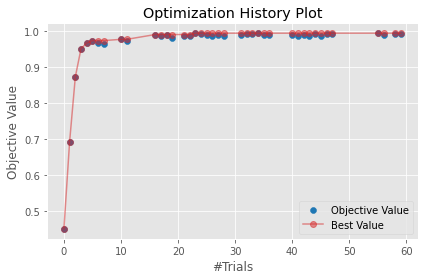

In [55]:
# optuna.visualization.plot_optimization_history(study)  #visualizing the tuning 
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.rcParams['figure.figsize']=[6,6]
plt.rcParams['figure.facecolor'] = 'white'
plt.tight_layout()
plt.savefig('/kaggle/working/opt_hist_plot.png', dpi=600, bbox_inches="tight")
#plt.savefig('/kaggle/working/gblurred_sample_imgs.png', dpi=600, bbox_inches="tight")  #sample images and their corresponding andom rotations
plt.show()

In [57]:
optuna.visualization.plot_param_importances(study) #visualizing the parameter importances  #what is the difference between this plot and the one below

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: ExperimentalWarning:

plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.



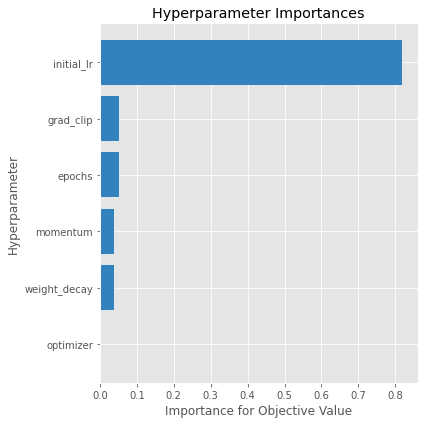

In [58]:
optuna.visualization.matplotlib.plot_param_importances(study) #i can modify the plot
plt.tight_layout()
plt.rcParams['figure.figsize']=[6,6]
plt.savefig('/kaggle/working/hyparam_importances_plot.png', dpi=600, bbox_inches="tight")
#plt.grid(color='#EAE4E3')
plt.show()

In [ ]:
optuna.visualization.matplotlib.plot_contour

In [ ]:
optuna.visualization.matplotlib.plot_edf(study)

---------------------

### ResNet-9 model training with optimized hyperparameters

In [48]:
epochs = 14
momentum = 0.4
grad_clip = 0.2
initial_lr = 0.012
weight_decay = 0.0001
opt_func = torch.optim.SGD

history = fit_OneCycle(epochs, initial_lr, model, train_dl, valid_dl, 
                       momentum=0.4, 
                       grad_clip=0.2, 
                       weight_decay=0.0001, 
                       opt_func=opt_func)

Epoch [0], last_lr: 0.00201, train_loss: 0.4501, train_accuracy: 0.8398, val_loss: 0.3872, val_acc: 0.8574
Epoch [1], last_lr: 0.00580, train_loss: 0.2443, train_accuracy: 0.9225, val_loss: 0.5594, val_acc: 0.8529
Epoch [2], last_lr: 0.00983, train_loss: 0.2154, train_accuracy: 0.9383, val_loss: 0.3435, val_acc: 0.9241
Epoch [3], last_lr: 0.01194, train_loss: 0.1305, train_accuracy: 0.9642, val_loss: 0.4587, val_acc: 0.9005
Epoch [4], last_lr: 0.01180, train_loss: 0.1030, train_accuracy: 0.9744, val_loss: 0.2457, val_acc: 0.9561
Epoch [5], last_lr: 0.01103, train_loss: 0.0649, train_accuracy: 0.9832, val_loss: 0.2216, val_acc: 0.9591
Epoch [6], last_lr: 0.00974, train_loss: 0.0515, train_accuracy: 0.9877, val_loss: 0.3644, val_acc: 0.9420
Epoch [7], last_lr: 0.00807, train_loss: 0.0262, train_accuracy: 0.9921, val_loss: 0.0993, val_acc: 0.9799
Epoch [8], last_lr: 0.00619, train_loss: 0.0073, train_accuracy: 0.9971, val_loss: 0.0992, val_acc: 0.9792
Epoch [9], last_lr: 0.00429, train_lo

---------------------------------

### Plotting accuracies and losses

In [49]:
def plot_accuracies(history):
    """This function plots both training and validation accuracies of ResNet-9 model"""
    plt.rcParams['figure.figsize'] = [8, 8]
    epochs = [i for i in range(1, epochs+1)]
    val_accuracies = [x['val_accuracy'] for x in history]
    train_accuracies = [x['train_accuracy'] for x in history]
    plt.plot(epochs, train_accuracies, '-o', color='blue', label='train_loss')
    plt.plot(epochs, val_accuracies, '-o', color='green', label='validation_loss')
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
    plt.xlabel('Epochs', size=13)
    plt.ylabel('Accuracies', size=13)
    plt.grid(color='#EAE4E3')
    #plt.xticks(rotation=90)
    plt.title('Training and validation accuracies of ResNet-9', size=13)
    plt.legend()
    plt.savefig('../working/resnet9-tv-accuracies.png', dpi=600,  bbox_inches="tight")
    plt.show()
    
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [8, 8]
    epochs = [i for i in range(1, epochs+1)]
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x.get('val_loss').cpu().numpy() for x in history]
    plt.plot(epochs, train_losses, '-o', color='blue', label='train_loss')
    plt.plot(epochs, val_losses, '-o', color='green', label='validation_loss')
    plt.xticks(np.arange(min(epochs), max(epochs)+1, 1.0))
    plt.xlabel('Epochs', size=13)
    plt.ylabel('Losses', size=13)
    plt.grid(color='#EAE4E3')
    #plt.xticks(rotation=90)
    plt.title('Training and validation losses of ResNet-9', size=13)
    plt.legend()
    plt.savefig('../working/resnet9-tv-losses.png', dpi=600,  bbox_inches="tight")
    plt.show()

#### Accuracies

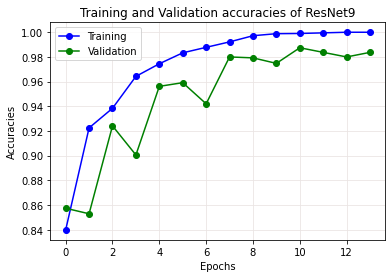

In [50]:
#Validation accuracy
plot_accuracies(history)

#### Losses

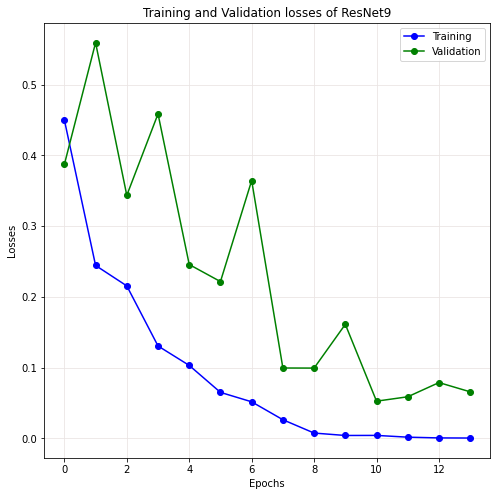

In [52]:
#Validation loss
plot_losses(history)

### Test data preparation

In [53]:
###Creating a new test dir because there was an svn file or folder found in the test dir
os.mkdir('../test_data')
os.mkdir('../test_data/test')

In [54]:
test_dir_old = test_dir
test_dir_new = '../test_data'
print(test_dir_old)
print(test_dir_new)

/kaggle/input/dataset/idata/Image Dataset/test_data/
../test_data


In [55]:
test_dir_old

'/kaggle/input/dataset/idata/Image Dataset/test_data/'

In [56]:
# import os
for f in os.listdir(f'{test_dir_new}/test'):
    os.remove(f'{test_dir_new}/test/{f}')

In [57]:
os.listdir(f'{test_dir_new}/test')

[]

In [58]:
for theclass in train.classes:
#     print(f"{test_dir_new}/test/{theclass}")
    os.mkdir(f"{test_dir_new}/test/{theclass}")

In [59]:
os.listdir(f'{test_dir_new}/test')

['potato_healthy',
 'tomato_late',
 'potato_late',
 'tomato_healthy',
 'potato_early',
 'tomato_early']

In [60]:
###Moving file from old test dir to new test dir
num_moved = 0
for img in os.listdir(test_dir_old+'/test'):
    if img.endswith('.JPG'):
        theclass = img.split('_')[0] + '_' + img.split('.')[0].split('_')[1]
        #print(theclass)
        shutil.copy(f"{test_dir_old+'/test/'}{img}", f"{test_dir_new+'/test/'+theclass+'/'+img}")
        num_moved += 1
    elif img.endswith('svn'):
        print('not going to move you!')
print(f"Number of files moved: {num_moved}")

not going to move you!
Number of files moved: 1331


In [61]:
len(os.listdir(f'{test_dir_new}/test/potato_early'))

221

In [62]:
len(os.listdir('../test_data/test')) #files have been moved

6

In [63]:
os.listdir(f"{test_dir_new}")

['test']

In [64]:
#Testing model on test data
test = ImageFolder('../test_data/test', transform=transforms.Compose(
                                        [transforms.Resize([256, 256]),
                                         transforms.ToTensor()]))

In [65]:
test

Dataset ImageFolder
    Number of datapoints: 1331
    Root location: ../test_data/test
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [66]:
test_images = sorted(os.listdir(test_dir_new + '/test')) # since images in test folder are not in alphabetical order
#test_images

In [67]:
def predict_image(img, model):
    """Converts image to array and return the predicted class
        with highest probability"""
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label

    return train.classes[preds[0].item()]

In [68]:
len(test)

1331

In [69]:
img, label = test[-1]
label

5

In [70]:
print(len(test_images))
print(len(test))

6
1331


### ResNet-9 model evluation on test data

IndexError: list index out of range

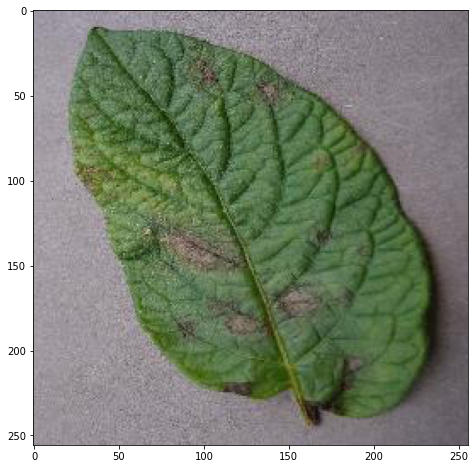

In [71]:
# predicting first image
img, label = test[-1000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[-1000], ', Predicted:', predict_image(img, model))

In [79]:
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [80]:
predictions =[] #code adapted from https://stackoverflow.com/questions/63647547/how-to-find-confusion-matrix-and-plot-it-for-image-classifier-in-pytorch
targets = []
for images, labels in test_loader_r:
    images, labels = images.cuda(), labels.cuda()
    logps = model(images)
    output = torch.exp(logps)
    pred = torch.argmax(output, 1)

    # convert to numpy arrays
    pred = pred.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    for i in range(len(pred)):
        predictions.append(pred[i])
        targets.append(labels[i])

In [81]:
train.classes

['potato_early',
 'potato_healthy',
 'potato_late',
 'tomato_early',
 'tomato_healthy',
 'tomato_late']

In [82]:
targets[:5]

[0, 5, 2, 4, 0]

In [83]:
predictions[:5]

[0, 5, 2, 4, 0]

In [84]:
cf_matrix = confusion_matrix(targets, predictions)
cf_matrix

array([[221,   0,   0,   0,   0,   0],
       [  0,  30,   0,   0,   0,   0],
       [  1,   0, 215,   0,   0,   5],
       [  0,   0,   1, 216,   0,   4],
       [  0,   0,   0,   0, 220,   0],
       [  1,   0,   1,   2,   0, 414]])

In [85]:
class_names = train.classes
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

potato_early  potato_healthy  potato_late  tomato_early  \
potato_early             221               0            0             0   
potato_healthy             0              30            0             0   
potato_late                1               0          215             0   
tomato_early               0               0            1           216   
tomato_healthy             0               0            0             0   
tomato_late                1               0            1             2   

                tomato_healthy  tomato_late  
potato_early                 0            0  
potato_healthy               0            0  
potato_late                  0            5  
tomato_early                 0            4  
tomato_healthy             220            0  
tomato_late                  0          414

#### Confusion matrix

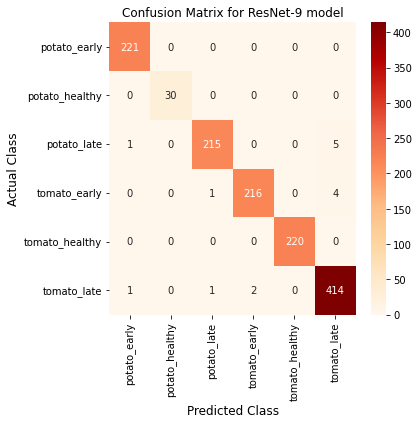

In [86]:
plt.figure(figsize=(6, 6))  #change size to 4, 4?

#Create heatmap
sns.heatmap(dataframe, annot=True, cbar=True,cmap="OrRd",fmt="d") #'purples', 'PuRd'
plt.title("Confusion Matrix for ResNet-9 model", size=12), plt.tight_layout()
 
plt.ylabel("Actual Class", size=12), 
plt.xlabel("Predicted Class",  size=12)
plt.tight_layout()
#plt.savefig('../working/cmatrxresnet9.png', dpi=600,  bbox_inches="tight")
plt.show()

#### Accuracy and classification report

In [87]:
print("Test Accuracy : {}".format(accuracy_score(targets, predictions)))
print("\nConfusion Matrix : ")
print(confusion_matrix(targets, predictions))
print("\nClassification Report :")
print(classification_report(targets, predictions, target_names=train.classes))

Test Accuracy : 0.9887302779864763

Confusion Matrix : 
[[221   0   0   0   0   0]
 [  0  30   0   0   0   0]
 [  1   0 215   0   0   5]
 [  0   0   1 216   0   4]
 [  0   0   0   0 220   0]
 [  1   0   1   2   0 414]]

Classification Report :
                precision    recall  f1-score   support

  potato_early       0.99      1.00      1.00       221
potato_healthy       1.00      1.00      1.00        30
   potato_late       0.99      0.97      0.98       221
  tomato_early       0.99      0.98      0.98       221
tomato_healthy       1.00      1.00      1.00       220
   tomato_late       0.98      0.99      0.98       418

      accuracy                           0.99      1331
     macro avg       0.99      0.99      0.99      1331
  weighted avg       0.99      0.99      0.99      1331



### Saving the model

In [ ]:
# saving to the kaggle working directory ###check this again
PATH1 = './resnet9-mdlsd.pth'  
torch.save(model.state_dict(), PATH1)

PATH2 = './resnet9-mdl.pth' 
torch.save(model, PATH2)

---------------------------------

### Model Explanations (DeepShap and Saliency Maps)

In [ ]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
test_loader_r = torch.utils.data.DataLoader(test, 
                                            batch_size=batch_size,
                                            shuffle=True)

test_loader_r = DeviceDataLoader(test_loader_r, device)
test_loader_r

In [ ]:
# since shuffle=True, this is a random sample of test data
images, targets =  next(iter(test_loader_r))
BACKGROUND_SIZE = 20
background_images = images[:BACKGROUND_SIZE]
background_targets = targets[:BACKGROUND_SIZE].cpu().numpy()
#increase the size after you've fixed everything 

test_images = images[BACKGROUND_SIZE:BACKGROUND_SIZE+9]
test_targets = targets[BACKGROUND_SIZE:BACKGROUND_SIZE+9].cpu().numpy()
def show_attributions(model):
    # predict the probabilities of the digits using the test images
    output = model(test_images.to(device))
    # get the index of the max log-probability
    pred = output.max(1, keepdim=True)[1] 
    # convert to numpy only once to save time
    pred_np = pred.cpu().numpy() 

    expl = shap.DeepExplainer(model, background_images)
    train_classes = ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late'] 
    for i in range(0, len(test_images)):
        warnings.filterwarnings('ignore')
        
        torch.cuda.empty_cache()
        ti = test_images[[i]]
        sv = expl.shap_values(ti)
        sn = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in sv]
        tn = np.swapaxes(np.swapaxes(ti.cpu().numpy(), 1, -1), 1, 2) #.cpu().numpy()?

        # Prepare the attribution plot, but do not draw it yet
        # We will add more info to the plots later in the code
        shap.image_plot(sn, -tn, show=False)

        # Prepare to augment the plot
        fig = plt.gcf()
        allaxes = fig.get_axes()

        allaxes[0].set_title('Actual: {}, Pred: {}'.format(train_classes[test_targets[i]], train_classes[pred_np[i][0]]), fontsize=10)
        
        
        prob = output[i].detach().cpu().numpy()
        for x in range(1, len(allaxes)-1):
            #allaxes[x].set_title('{}'.format(train_classes[x-1]), fontsize=10)
            allaxes[x].set_title('{}({:.2%})'.format(train_classes[x-1], prob[x-1]), fontsize=10)
            allaxes[0].imshow(test_images[i].cpu().permute(1, 2, 0))       
         

        plt.show()

In [ ]:
feature_attributions = show_attributions(model)
feature_attributions